# Tratamiento de la Base de Datos scraped
En este cuadreno Jupyter se pretende, tratar los datos extraídos de diferentes webs de oferta de empleo, para ver que puestos están mejor pagados, cuanto se cobra hoy en día en x puesto...

## Preambulo
El cuaderno esta pensado para que se ejecute de forma secuencial, se debe ir ejecutando celda a celda.

In [5]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# 1. Cargamos los datos brutos que conseguiste
df = pd.read_csv("../data/ofertas_generico.csv")

# 2. Función "limpiadora" (Parsing)
# Vamos a usar Regex (Expresiones Regulares) para separar el sueldo del texto
def limpiar_oferta(row):
    texto = row['contenido']
    
    # Sobre la columna de contenido, se encuentra texto separado por pipes "|", 
    # quiero generalizar la extracción del sueldo bruto mensual, y demás campos.
    # ejemplo de fila: "VER OFERTA |  | Sr. Service Desk Especialist |  | SALARIO | Hasta €35K | VARIABLE | €2,838K | UBICACIÓN | Madrid | y | TELETRABAJO | 60% | 🌎 Equipo internacional | 🏠 Híbrido | 🕐 Horario Flexible | ⛰️ Sólida en su sector",https://www.getmanfred.com/ofertas-empleo/8239/namirial-senior-servidesk-specialist-ene26,2026-01-20
    # Vamos a iterar sobre el texto para extraer el salario anual bruto en euros, variable si existe, Ubicación si existe, y modalidad de trabajo (presencial, Híbrido o telemático).
    # Regex para sueldo bruto mensual en euros (puede tener formato €2,838K o €2838 o €2.838)
    sueldo_pattern = r'€\s*([0-9,.K-]+?)(?:\s*\||$)'
    sueldo_match = re.search(sueldo_pattern, texto)
    sueldo = 0
    if sueldo_match:
        cantidad_str = sueldo_match.group(1).strip()
        # Extraer el valor medio (ej: "30-50K" -> "40")
        if '-' in cantidad_str:
            partes = cantidad_str.split('-')
            if partes[1].endswith('K'):
                partes[1] = partes[1].replace('K','')
                partes[0] = int(partes[0]) * 1000
                partes[1] = int(partes[1]) * 1000
            cantidad_str = str((int(partes[0]) + int(partes[1])) // 2)
        # Convertir K a miles
        if 'K' in cantidad_str:
            cantidad_str = cantidad_str.replace('K', '').replace(',', '').replace('.', '')
            cantidad = str(int(float(cantidad_str)) * 1000)
        else:
            cantidad = cantidad_str.replace(',', '').replace('.', '')
        sueldo = int(cantidad)
    
    # Ubicación
    ubicacion_pattern = r'UBICACIÓN\s*\|\s*([^\|]+)'
    ubicacion_match = re.search(ubicacion_pattern, texto)
    ubicacion = ubicacion_match.group(1).strip() if ubicacion_match else "N/A"

    # Modalidad de trabajo - más robusta
    modalidad = "N/A"
    # Primero buscamos el patrón "TELETRABAJO | porcentaje"
    modalidad_pattern = r'TELETRABAJO\s*\|\s*(\d+)%'
    modalidad_match = re.search(modalidad_pattern, texto)
    if modalidad_match:
        porcentaje = int(modalidad_match.group(1))
        if porcentaje == 100:
            modalidad = "Telemático"
        elif porcentaje == 0:
            modalidad = "Presencial"
        else:
            modalidad = "Híbrido"
    else:
        # Si no encontramos TELETRABAJO, buscamos palabras clave
        if re.search(r'Híbrido', texto, re.IGNORECASE):
            modalidad = "Híbrido"
        elif re.search(r'Presencial', texto, re.IGNORECASE):
            modalidad = "Presencial"
        elif re.search(r'Telemático|Remoto|100% remoto', texto, re.IGNORECASE):
            modalidad = "Telemático"
    
    # Generamos un array, por el pipe "|" que pusimos en el scraper
    partes = [p.strip() for p in texto.split('|')]
    
    return pd.Series({
        'Puesto': partes[2] if len(partes) > 0 else "N/A",
        # 'Empresa': partes[1] if len(partes) > 1 else "N/A",
        'Sueldo_Bruto': sueldo if sueldo != 0 else "N/A",
        'Ubicación': ubicacion,
        'Modalidad_Trabajo': modalidad,
        'URL': row['url'],
        'Fecha_Captura': row['fecha_captura']
    })

# 3. Aplicamos la limpieza a todo el DataFrame
df_limpio = df.apply(limpiar_oferta, axis=1)
# Si es Telemático, rellenamos la ubicación con 'Remoto' para que el gráfico sea más limpio
df_limpio.loc[df_limpio['Modalidad_Trabajo'] == 'Telemático', 'Ubicación'] = 'Remoto'

# 4. Ver el resultado (esto en VS Code se ve como una tabla de Excel preciosa)
df_limpio.info()
df_limpio = df_limpio.sort_values('Sueldo_Bruto', ascending=True)
df_limpio.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Puesto             33 non-null     object
 1   Sueldo_Bruto       33 non-null     int64 
 2   Ubicación          33 non-null     object
 3   Modalidad_Trabajo  33 non-null     object
 4   URL                33 non-null     object
 5   Fecha_Captura      33 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.7+ KB


,Puesto,Sueldo_Bruto,Ubicación,Modalidad_Trabajo,URL,Fecha_Captura
25,Junior Fullstack Developer,29000,Madrid,Híbrido,https://www.getmanfred.com/ofertas-empleo/8227...,2026-01-20
0,Sr. Service Desk Especialist,35000,Madrid,Híbrido,https://www.getmanfred.com/ofertas-empleo/8239...,2026-01-20
3,Growth Consultant,35000,Remoto,Telemático,https://www.getmanfred.com/ofertas-empleo/8229...,2026-01-20
5,.Net Developer,40000,Madrid,Híbrido,https://www.getmanfred.com/ofertas-empleo/7681...,2026-01-20
18,Java Developer,40000,Sevilla,Híbrido,https://www.getmanfred.com/ofertas-empleo/8208...,2026-01-20


C:\Users\samua\AppData\Local\Temp\ipykernel_17176\2412857959.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Sueldo_Bruto', y='Puesto', data=df_sorted, palette='viridis')


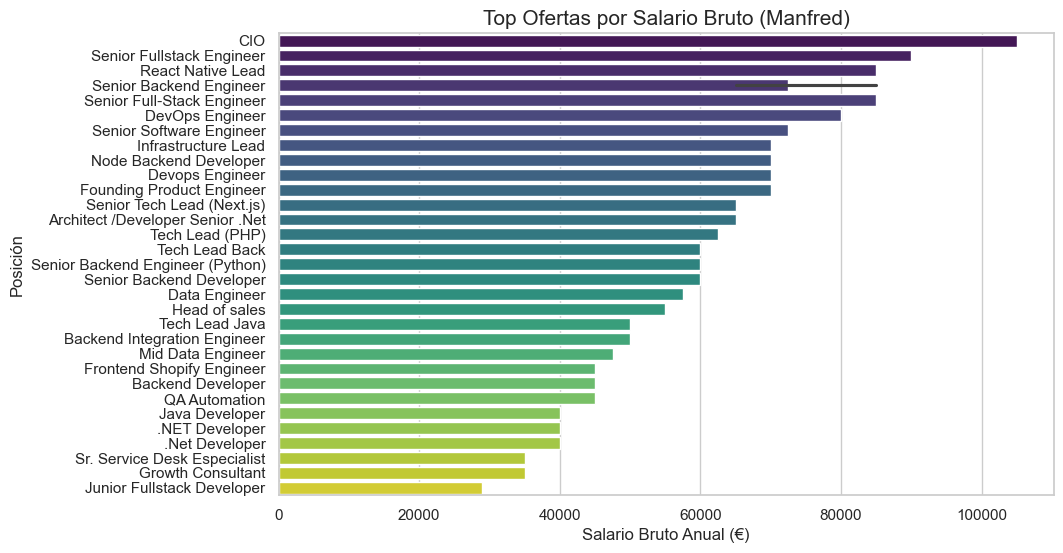

In [ ]:
# Configuramos el estilo
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Ordenamos por sueldo para que el gráfico sea legible
df_sorted = df_limpio.sort_values('Sueldo_Bruto', ascending=False)

# Creamos el gráfico
ax = sns.barplot(x='Sueldo_Bruto', y='Puesto', data=df_sorted, palette='viridis')

# Añadimos etiquetas de datos
plt.title('Top Ofertas por Salario Bruto (Manfred)', fontsize=15)
plt.xlabel('Salario Bruto Anual (€)', fontsize=12)
plt.ylabel('Posición', fontsize=12)

plt.show()

### Modalidad de trabajo vs Sueldo
Para intentar algún dato interesante de este df, vamos a calcular la correlación de la modalidad del trabajo frente al sueldo que se cobra. ¿Se cobra más en trabajos presenciales?

Estadísticas de Sueldo por Modalidad:
                           mean   median  count    min     max
Modalidad_Trabajo                                             
Híbrido            58326.086957  57500.0     23  29000  105000
N/A                60000.000000  60000.0      1  60000   60000
Telemático         66666.666667  70000.0      9  35000   85000


C:\Users\samua\AppData\Local\Temp\ipykernel_17176\1249956971.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Modalidad_Trabajo', y='Sueldo_Bruto', data=df_limpio, palette="Set2")


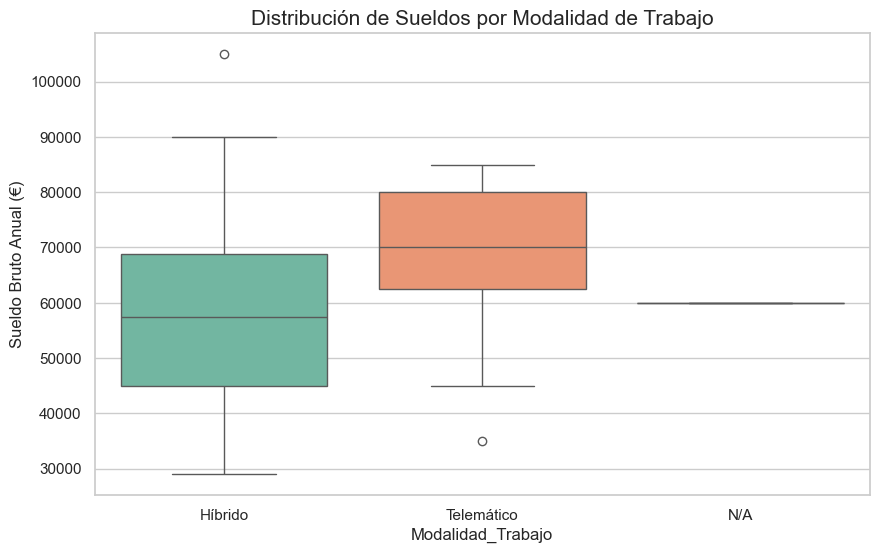

In [7]:
# 1. Agrupamos por modalidad y sacamos estadísticas básicas
stats_modalidad = df_limpio.groupby('Modalidad_Trabajo')['Sueldo_Bruto'].agg(['mean', 'median', 'count', 'min', 'max'])
print("Estadísticas de Sueldo por Modalidad:")
print(stats_modalidad)

# 2. Visualización: Boxplot (Distribución de sueldos)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Modalidad_Trabajo', y='Sueldo_Bruto', data=df_limpio, palette="Set2")
plt.title('Distribución de Sueldos por Modalidad de Trabajo', fontsize=15)
plt.ylabel('Sueldo Bruto Anual (€)')
plt.show()

#### Conclusiones Modalidad vs Sueldo
Nuestro df no es lo suficientemente grande para sacar conclusiones, además la clase Híbrido tiene 23 ofertas y la clase telemático tiene 9 ofertas, por lo que se encuentra desbalanceado, y las conclusiones sacadas serán sesgadas y por tanto erróneas. En base a la muestra obtenida de 33 ofertas de empleo, los trabajos telemáticos suelen tener sueldos más altos. 